In [53]:
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import hvplot.pandas
from imblearn.combine import SMOTEENN
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkFiles


In [5]:
# spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

# Evaluating the correlation of cancer with risk factors

In [47]:
cancer_hr_df = pd.read_csv('data/cancer_health_risk_merged.csv')
cancer_hr_df.head()

,density,total_population,countyfips,cancer,binge,csmoking,lpa,sleep
0,94.3,56059,1001,6.5,15.0,19.7,32.2,38.4
1,141.8,225463,1003,6.7,19.0,19.9,27.6,36.4
2,27.8,24575,1005,6.2,13.7,27.8,41.6,40.9
3,36.0,22427,1007,6.5,15.6,25.2,37.7,40.1
4,89.9,57997,1009,6.7,15.7,22.2,33.3,38.8


In [48]:
#create loop to iterate through cancer_hr_df and classify any cancner rate 1 standard deviation above the mean as '1', and anything else 0
cancer_risk = []
for risk in cancer_hr_df['cancer']:
    if risk <= 6.96:
        cancer_risk.append("0")
    if risk > 6.96:
        cancer_risk.append("1")

cancer_hr_df['cancer_risk'] = cancer_risk
cancer_hr_df['cancer_risk'].value_counts()

0    3089
1      32
Name: cancer_risk, dtype: int64

In [49]:
X = cancer_hr_df.drop(['cancer_risk', 'cancer'], axis=1)
y = cancer_hr_df['cancer_risk'] 

In [50]:
data_scaler = StandardScaler()

In [51]:
# Fitting the scaler
cancer_data_scaled = data_scaler.fit_transform(cancer_hr_df)
cancer_data_scaled[:3]

array([[-0.09371725, -0.13959962, -1.93043438,  0.13366561, -0.97170058,
        -0.16660882,  0.31211134,  0.40164309, -0.10178084],
       [-0.06679187,  0.36874362, -1.93030287,  0.68438558,  0.31895152,
        -0.11884671, -0.47750885, -0.10180206, -0.10178084],
       [-0.13141279, -0.23407601, -1.93017136, -0.69241434, -1.39116251,
         1.76775682,  1.92568304,  1.03094953, -0.10178084]])

In [54]:
# Normal train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [55]:
# . comment explanantion of why SMOTEEN is used to randomly over and undersample data

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'0': 2739, '1': 2766})

In [56]:
# Fit a Logistic regression model using random undersampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [57]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[557, 216],
       [  3,   5]])

In [58]:
balanced_accuracy_score(y_test, y_pred)

0.6727846054333765

In [59]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.72      0.62      0.84      0.67      0.45       773
          1       0.02      0.62      0.72      0.04      0.67      0.45         8

avg / total       0.98      0.72      0.63      0.83      0.67      0.45       781



# Predicting the correlation of cancer with prevention services

In [60]:
cancer_p_df = pd.read_csv('data/cancer_prevention_merged.csv')
cancer_p_df.head()

,density,total_population,countyfips,cancer,access,checkup,dental,bpmed,cholscreen,mammouse,cervical,colon_screen,corem,corew
0,94.3,56059,1001,6.5,16.0,77.0,64.0,61.8,87.0,77.5,86.4,69.5,28.1,26.5
1,141.8,225463,1003,6.7,14.6,73.3,66.3,58.6,87.0,74.0,87.3,67.5,29.0,28.7
2,27.8,24575,1005,6.2,24.5,77.6,46.6,65.9,85.5,75.9,84.1,62.1,21.8,22.9
3,36.0,22427,1007,6.5,20.2,75.8,57.6,63.6,85.4,73.3,84.8,65.7,24.7,24.8
4,89.9,57997,1009,6.7,19.8,74.8,57.1,61.0,85.2,71.5,84.1,63.9,25.4,24.8


In [61]:
#create loop to iterate through cancer_p_df and classify any cancner rate 1 standard deviation above the mean as '1', and anything else 0
cancer_risk = []
for risk in cancer_p_df['cancer']:
    if risk <= 6.96:
        cancer_risk.append("0")
    if risk > 6.96:
        cancer_risk.append("1")

cancer_p_df['cancer_risk'] = cancer_risk
cancer_p_df['cancer_risk'].value_counts()

0    3089
1      32
Name: cancer_risk, dtype: int64

In [62]:
cancer_p_df = cancer_p_df.drop(['cancer', 'countyfips', 'density', 'total_population',], axis = 1)

In [63]:
X = cancer_p_df.drop('cancer_risk', axis=1)
y = cancer_p_df['cancer_risk'] 

In [64]:
data_scaler = StandardScaler()

In [65]:
# Fitting the scaler
cancer_data_scaled = data_scaler.fit_transform(cancer_p_df)
cancer_data_scaled[:3]

array([[-0.34710425,  0.76142327,  0.52275462,  1.03720275,  1.37466056,
         1.67990085,  1.31616155,  1.59513793,  1.24186116,  1.18052392,
        -0.10178084],
       [-0.55182838, -0.17430747,  0.82639339,  0.2174024 ,  1.37466056,
         0.81111552,  1.78465975,  1.17478707,  1.48067701,  1.81636089,
        -0.10178084],
       [ 0.89586369,  0.91316339, -1.77433874,  2.08757196,  0.78580064,
         1.28274184,  0.11888836,  0.03983973, -0.42984984,  0.14006342,
        -0.10178084]])

In [66]:
# Normal train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
# Use the SMOTEENN technique to perform combination sampling on the data
# Count the resampled classes
# implement random oversampling

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'0': 2970, '1': 3086})

In [69]:
# Fit a Logistic regression model using random undersampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

/Users/halesoyster/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=1)

In [70]:
# Display the confusion matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[669, 104],
       [  1,   7]])

In [71]:
balanced_accuracy_score(y_test, y_pred)

0.8702296248382924

In [72]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.87      0.88      0.93      0.87      0.76       773
          1       0.06      0.88      0.87      0.12      0.87      0.76         8

avg / total       0.99      0.87      0.87      0.92      0.87      0.76       781



# Plotting

from https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [34]:
# from matplotlib import pyplot
# importance = model.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()


This is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

0-4 features seem to very important, while 5-9 are less so.  

work on creating titles for features (coeffeicients) to match column names

# Use numpy to show impact of each element

from https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

In [73]:
import numpy as np
def get_score_after_permutation(model, X, y, curr_feat):
     """ return the score of model when curr_feat is permuted """

     X_permuted = X.copy()
     col_idx = list(X.columns).index(curr_feat)
     # permute one column
     X_permuted.iloc[:, col_idx] = np.random.permutation(
         X_permuted[curr_feat].values)

     permuted_score = model.score(X_permuted, y)
     return permuted_score


def get_feature_importance(model, X, y, curr_feat):
     """ compare the score when curr_feat is permuted """

     baseline_score_train = model.score(X, y)
     permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

     # feature importance is the difference between the two scores
     feature_importance = baseline_score_train - permuted_score_train
     return feature_importance


curr_feat = 'access'

feature_importance = get_feature_importance(model, X_train, y_train, curr_feat)
# print(f'feature importance of "{curr_feat}" on train set is '
#       f'{feature_importance:.3}')

Since there is some randomness, it is advisable to run it multiple times and inspect the mean and the standard deviation of the feature importance.

In [75]:
# n_repeats = 10

# list_feature_importance = []
# for n_round in range(n_repeats):
#     list_feature_importance.append(
#         get_feature_importance(model, X_train, y_train, curr_feat))

# print(
#     f'feature importance of "{curr_feat}" on train set is '
#     f'{np.mean(list_feature_importance):.3} '
#     f'± {np.std(list_feature_importance):.3}')

In [76]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

In [77]:
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

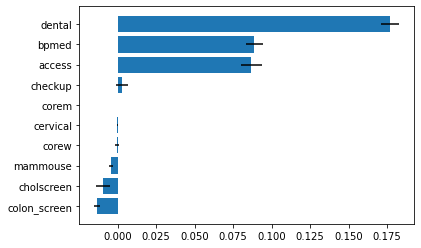

In [78]:
perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=10)

plot_feature_importances(perm_importance_result_train, X_train.columns)